# Caption Generation Project

**Business question:** can we create an application that, given an image as an input, can respond with an appropriate and grammatically correct caption that best describes the image’s content?

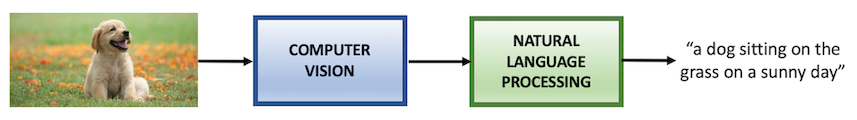

IMAGE CAPTIONING is the task of generating textual descriptions of a given image, requiring techniques of **COMPUTER VISION** and **NATURAL LANGUAGE PROCESSING**. <br>
It is a process of recognizing the context of an image and annotating it with relevant captions with the help of datasets provided during model training. <br>
For this purpose, we need to process both the language or statements and the images. For the Language part, we use recurrent Neural Networks (RNN) and for the Image part, we use Convolutional Neural Networks (CNN) to obtain the feature vectors respectively. In this case, the features of each image will be extracted by a CNN encoder which uses a pre-trained ResNet model provided by Pytorch. <br>
The extracted features will be fed to a LSTM decoder which in turn generates a possible image caption. MS-COCO is one of the most used datasets for this purpose. <br>
"It has been convincingly
shown that CNNs can produce a rich representation of the
input image by embedding it to a fixed-length vector, such
that this representation can be used for a variety of vision tasks. Hence, it is natural to use a CNN as an image
“encoder”, by first pre-training it for an image classification
task and using the last hidden layer as an input to the RNN
decoder that generates sentences" <br>
[*Show and Tell: A Neural Image Caption Generator*](https://arxiv.org/pdf/1411.4555.pdf)



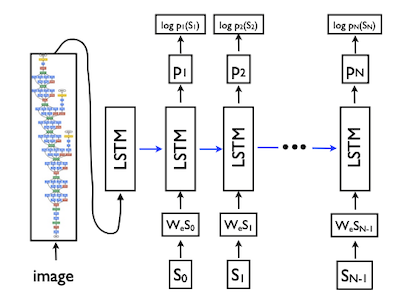

Overview of the topics for this project
- Exploring COCO dataset
- Preprocessing images and captions
- Encoder: pre-trained CNN with ResNet 152
- Decoder: LSTM for training and testing
- Rouge_L metrics 
- Coco Evaluation toolkit 


## About COCO dataset

DATASET: <br>
http://images.cocodataset.org/zips/val2014.zip <br>
<br>
DEMO file: <br>
https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb <br>
<br>
**pycocotools** is a Python API that assists in loading, parsing, and visualizing the annotations 
in the dataset. <br>

Structure of the data (json): <br>
```
image
{
"id": int, 
"width": int, 
"height": int, 
"file_name": str, 
"license": int, 
"flickr_url": str, 
"coco_url": str, 
"date_captured": datetime,
}
``` 
CAPTIONS: These annotations are used to store image captions. Each caption describes the specified image and each image has at least 5 captions (some images have more). <br>
```
annotation
{
"id": int, 
"image_id": int, 
"caption": str,
}
``` 

In [ ]:
!pip install pycocotools # install pycocotools (not needed if in google colab)

In [11]:
from pycocotools.coco import COCO   # COCO python library

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

import random
import string
import nltk
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords

import cv2
import os
from pickle import dump, load
import json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
# reading the captions (annotations) file into "coco_caps"
annFile = "data/captions_val2014.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


In [14]:
# number of images (imgIds)
imgIds = coco_caps.getImgIds()
print(type(imgIds))
len(imgIds)

<class 'list'>


40504

In [15]:
# number of annotations (captions Ids)
annIds = coco_caps.getAnnIds()
len(annIds)

202654

<class 'dict'>
imgID:  467863
A man sitting on a bench next to a river under a bridge.
A man is sitting on a bench under a bridge watching the sunset.
A young man sitting on a bench under the bridge 
A man sitting on a bench by the water under a bridge.
A man sits and admires the architecture of a large bridge.


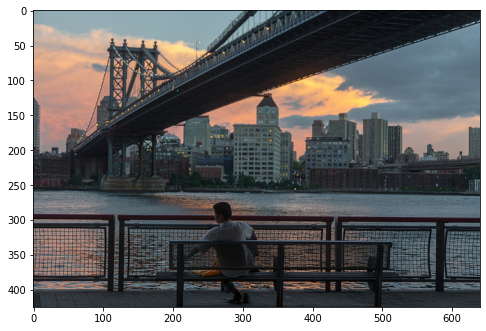

width:  640
height:  425


In [ ]:
# loading a random image and getting the correspondent annotations (captions)
img = coco_caps.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(type(img))
print("imgID: ",img['id'])
I = io.imread(img['coco_url'])
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(I)
plt.show()
print("width: ",img['width'])
print("height: ",img['height'])

### Working with a sample
In order to reduce the running time while working with the model, the code below is useful to get a sample of the dataset.

In [16]:
# sampling the data (to reduce processing time)
all_caps_ann_ids = coco_caps.getAnnIds()
#random.seed(42)
# shuffle and limit captions to a certain number ---
#random.shuffle(all_caps_ann_ids)
caps_ann_ids = all_caps_ann_ids[:50000]
test_caps_ann_ids = all_caps_ann_ids[150000:152000]

## Preparing the DATA 
**1- Captions** <br>
  - everything in lower case
  - tokenize (to words)<br>
```python
tokens = nltk.tokenize.word_tokenize(str(caption).lower())
```
  - add "start_word" and "end_word" to each sentence
```python
caption = []
caption.append('<start>')
caption.extend([token for token in tokens])
caption.append('<end>')
```
  - vocabulary threshold 
  - add unknown words (below threshold)
  - indexing (words to numbers)
  - convert them to PyTorch tensors<br>

The last steps will be done with the help of the Vocabulary class. 
<br>

**2- Images** <br>

"*All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]." [ResNet by Pytorch team](https://pytorch.org/hub/pytorch_vision_resnet/)*
  - resize images 
  - data augmentation
  - normalize values (according to pre-trained model)
  - convert them to PyTorch tensors 
  ```python
  transform = transforms.Compose([
      transforms.Resize(config_size),
      transforms.RandomCrop(config_crop_size),
      transforms.RandomHorizontalFlip(), 
      transforms.ToTensor(), 
      transforms.Normalize((0.485, 0.456, 0.406), 
                          (0.229, 0.224, 0.225))])
  ```


In [ ]:
originalcaption = "The dog is sitting on the grass on a sunny day."
tokens = nltk.tokenize.word_tokenize(str(caption).lower())
caption = []
caption.append('<start>')
caption.extend([token for token in tokens])
caption.append('<end>')
caption

['<start>',
 'the',
 'dog',
 'is',
 'sitting',
 'on',
 'the',
 'grass',
 'on',
 'a',
 'sunny',
 'day',
 '.',
 '<end>']

In [ ]:
from torchvision import transforms
transform = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

path = coco_caps.loadImgs(img['id'])[0]['coco_url']
image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
image = transform(image)
image.shape


torch.Size([3, 224, 224])

###Vocabulary
The word2idx dictionary is created by looping over the captions in the training dataset. If a token appears no less than **vocab_threshold** times in the training set, then it is added as a key to the dictionary and assigned a corresponding unique integer. <br>
We will be able to choose later the vocab_threshold number before training the model. Smaller values for vocab_threshold yield a larger number of tokens in the vocabulary. <br>
<br>
Some words are added to mark the beginning and the end of each caption (start and end). The words that appear less than vocab_threshold are set as unknown words (unk). 


In [8]:
# Vocabulary
import nltk
import pickle
from collections import Counter

class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """adding words and respective indexes to the vocabulary"""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        """calling words as unknown"""
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(threshold):
    counter = Counter()
    
    for i, id in enumerate(caps_ann_ids):
        caption = str(coco_caps.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 5000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(caps_ann_ids)))
    
    # Add only the words with frequency higher than threshold.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocabulary and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    print("Total vocabulary size: {}".format(len(vocab)))
    return vocab

In [17]:
# Choose the vocab_threshold to get the vocab_length 
build_vocab(5)

[5000/50000] Tokenized the captions.
[10000/50000] Tokenized the captions.
[15000/50000] Tokenized the captions.
[20000/50000] Tokenized the captions.
[25000/50000] Tokenized the captions.
[30000/50000] Tokenized the captions.
[35000/50000] Tokenized the captions.
[40000/50000] Tokenized the captions.
[45000/50000] Tokenized the captions.
[50000/50000] Tokenized the captions.
Total vocabulary size: 3189


###Data Loader

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. **Dataset** stores the samples and their corresponding labels, and **DataLoader** wraps an iterable around the Dataset to enable easy access to the samples.<br>
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html <br>
<br>
the function passed as the **collate_fn** argument is used to collate lists of samples into batches. <br>
https://pytorch.org/docs/stable/data.html#dataloader-collate-fn

In [18]:
# DATA LOADER
   
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
from tqdm import tqdm
import nltk
from PIL import Image
import requests

class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, coco_anns, ann_ids, vocab, transform=None):
        self.coco = coco_anns
        self.ids = ann_ids
        self.vocab = vocab
        self.transform = transform
        all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
        self.caption_lengths = [len(token) for token in all_tokens]

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['coco_url']

        # Read image from the network using requests. Could be done via Image Array
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates batch tensors from the list of tuples (image, caption).
    
    caption: torch tensor of variable length.
    targets: torch tensor of shape (batch_size, padded_length).
    lengths: list; length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Batch images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Batch captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader(coco_anns, ann_ids, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""

    coco_dataset = CocoDataset(coco_anns=coco_anns,
                       ann_ids=ann_ids,
                       vocab=vocab,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption.
    data_loader = torch.utils.data.DataLoader(dataset=coco_dataset, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

###Caption lengths distributon

The lengths of the captions in the dataset vary significantly. Examining data_loader.dataset.caption_lengths, a Python list with one entry for each training caption, it is possible to see the distribution in length for the captions.

In [ ]:
from collections import Counter
vocab = Vocabulary
config_batch_size = 1
config_num_workers = 1
data_loader = get_loader(coco_caps, caps_ann_ids, vocab, 
                          transform, config_batch_size,
                          shuffle=True, num_workers=config_num_workers) 

counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    print('length: %2d --- count: %5d' % (value, count))

100%|██████████| 50000/50000 [00:07<00:00, 6287.12it/s]

length: 10 --- count: 10427
length: 11 --- count:  9757
length:  9 --- count:  8811
length: 12 --- count:  6909
length: 13 --- count:  4590
length: 14 --- count:  2601
length:  8 --- count:  2521
length: 15 --- count:  1571
length: 16 --- count:   869
length: 17 --- count:   570
length: 18 --- count:   336
length: 19 --- count:   247
length:  7 --- count:   179
length: 20 --- count:   160
length: 21 --- count:   133
length: 22 --- count:    80
length: 24 --- count:    51
length: 23 --- count:    49
length: 25 --- count:    35
length: 26 --- count:    20
length: 27 --- count:    15
length: 31 --- count:    13
length: 29 --- count:    13
length: 28 --- count:    11
length: 30 --- count:     8
length: 37 --- count:     4
length: 33 --- count:     4
length: 32 --- count:     3
length: 53 --- count:     3
length: 43 --- count:     2
length: 38 --- count:     2
length: 50 --- count:     1
length:  6 --- count:     1
length: 45 --- count:     1
length: 52 --- count:     1
length: 34 --- count

### MODEL (CNN-LSTM)

### CNN - Convolutional Neural Network
It is used to process the data represented as a 2D matrix like images. It extracts relevant features from that. Finally, it combines all the features for image classification.

The encoder uses the pre-trained ResNet-152 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images. The output is then flattened to a vector, before being passed through a Linear layer to transform the feature vector to have the same size as the word embedding.

### LSTM - Long short-term memory
It is a type of RNN (recurrent neural network), and it is capable of working with sequence prediction problems. It is mostly used for the next word prediction purposes, as in Google search our system is showing the next word based on the previous text. Throughout the processing of inputs, LSTM is used to carry out the relevant information and to discard non-relevant information.
It is a special kind of RNN that includes a memory cell, in order to maintain the information for a longer period of time.

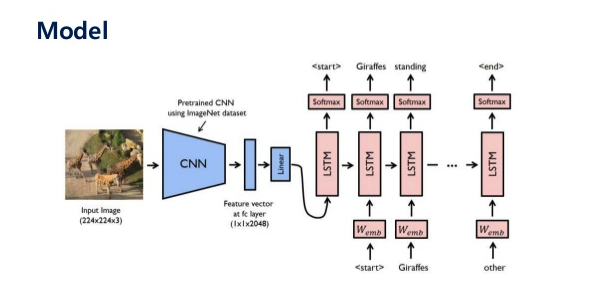

In [4]:
# Encoder
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [5]:
# Decoder 
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size) #from hidden to output (vocab) size
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

## Training

Due to limited resources, the model is set to run 4 epochs using 50.000 annotations, in batches of 32. It took less than 3 hours using GPU on Google Colab and already shows some reasonable results.

In [ ]:
#TRAINING 

import torch
import torch.nn as nn
import numpy as np
import os
import pickle
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

config_model_path = './models/'
config_crop_size = 224
config_log_step = 20
config_save_step = 1563 #50.000 captions divided by 32 (batch size), saved for each epoch

config_embed_size = 256
config_hidden_size = 512
config_num_layers = 1
    
config_num_epochs = 4 
config_batch_size = 32 
config_num_workers = 2
config_learning_rate = 0.001
config_vocab_threshold = 5 #results in a vocabulary of 3189 words, as seen before

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.Resize(config_crop_size),
    transforms.RandomCrop(config_crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                          (0.229, 0.224, 0.225))])

# Load vocabulary 
vocab = build_vocab(config_vocab_threshold)

# Build data loader
data_loader = get_loader(coco_caps, caps_ann_ids, vocab, 
                          transform, config_batch_size,
                          shuffle=True, num_workers=config_num_workers) 

# Build the models
encoder = EncoderCNN(config_embed_size).to(device)
decoder = DecoderRNN(config_embed_size, config_hidden_size, len(vocab), config_num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=config_learning_rate)

# Train the models
total_step = len(data_loader)
for epoch in range(config_num_epochs):
    for i, (images, captions, lengths) in enumerate(data_loader):
        
        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % config_log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, config_num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
            
        # Save the model 
        if (i+1) % config_save_step == 0:
            torch.save(decoder.state_dict(), os.path.join(
                config_model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder.state_dict(), os.path.join(
                config_model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                

[1000/50000] Tokenized the captions.
[2000/50000] Tokenized the captions.
[3000/50000] Tokenized the captions.
[4000/50000] Tokenized the captions.
[5000/50000] Tokenized the captions.
[6000/50000] Tokenized the captions.
[7000/50000] Tokenized the captions.
[8000/50000] Tokenized the captions.
[9000/50000] Tokenized the captions.
[10000/50000] Tokenized the captions.
[11000/50000] Tokenized the captions.
[12000/50000] Tokenized the captions.
[13000/50000] Tokenized the captions.
[14000/50000] Tokenized the captions.
[15000/50000] Tokenized the captions.
[16000/50000] Tokenized the captions.
[17000/50000] Tokenized the captions.
[18000/50000] Tokenized the captions.
[19000/50000] Tokenized the captions.
[20000/50000] Tokenized the captions.
[21000/50000] Tokenized the captions.
[22000/50000] Tokenized the captions.
[23000/50000] Tokenized the captions.
[24000/50000] Tokenized the captions.
[25000/50000] Tokenized the captions.
[26000/50000] Tokenized the captions.
[27000/50000] Tokeniz

## Predictions
During the test, no target caption is given to the decoder. Instead, the output of the decoder is fed back to the same and becomes the next input. 
The image features tensor is provisioned to the decoder.sample. The output is transformed back from indexes to words. 

In [22]:
# Predictions
import torch
import matplotlib.pyplot as plt
import numpy as np 
import pickle 
import os
from torchvision import transforms 
from PIL import Image
import requests

sample_config_encoder_path = 'models/encoder-4-1563.ckpt'
sample_config_decoder_path = 'models/decoder-4-1563.ckpt'
sample_config_embed_size = 256
sample_config_hidden_size = 512
sample_config_num_layers = 1
sample_config_vocab_threshold = 5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                          (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
vocab = build_vocab(sample_config_vocab_threshold)

# Build models
encoder = EncoderCNN(sample_config_embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(sample_config_embed_size, sample_config_hidden_size, len(vocab), sample_config_num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(sample_config_encoder_path, map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(sample_config_decoder_path, map_location=torch.device('cpu')))

def load_image(image_path, transform=None):
    image = Image.open(requests.get(image_path, stream=True).raw).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def sampled_ids_to_sentence(sampled_ids, vocab):
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption[1:-1])
    return sentence

def get_caption_for_image(test_image_path, print_output=False):
    # Prepare an image
    image = load_image(test_image_path, transform)
    image_tensor = image.to(device)

    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()    

    # Convert word_ids to words
    sampled_sentence = sampled_ids_to_sentence(sampled_ids, vocab)

    # Print out the image and the generated caption
    if(print_output):
        #print (sampled_sentence)
        image = Image.open(requests.get(test_image_path, stream=True).raw)
        plt.imshow(np.asarray(image))
    
    return sampled_sentence


[5000/50000] Tokenized the captions.
[10000/50000] Tokenized the captions.
[15000/50000] Tokenized the captions.
[20000/50000] Tokenized the captions.
[25000/50000] Tokenized the captions.
[30000/50000] Tokenized the captions.
[35000/50000] Tokenized the captions.
[40000/50000] Tokenized the captions.
[45000/50000] Tokenized the captions.
[50000/50000] Tokenized the captions.
Total vocabulary size: 3189


'a group of giraffes standing in a fenced in area .'

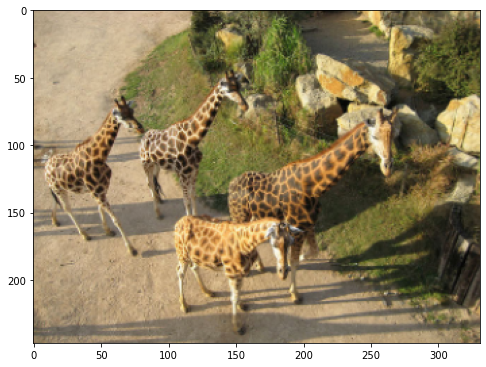

In [ ]:
get_caption_for_image('https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/example.png', True)

'a dog is sitting in the grass on a sunny day .'

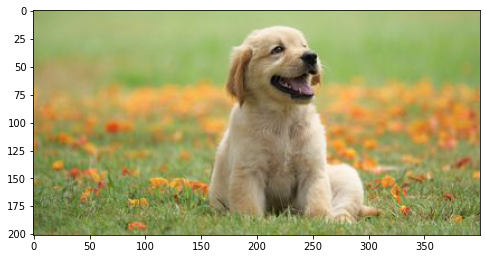

In [ ]:
get_caption_for_image('https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=400:*',True)

'a group of people standing around a park bench .'

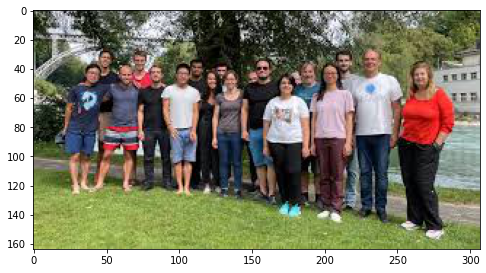

In [ ]:
get_caption_for_image('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS1CZJa0ZCC21GZkTreZeb1sF8ZV0I0FADTHg&usqp=CAU',True)

'a man riding a wave on a surfboard .'

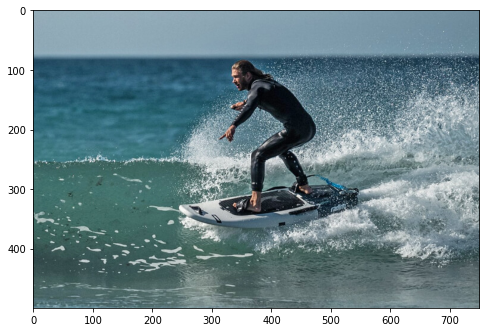

In [ ]:
get_caption_for_image('https://www.surfertoday.com/images/stories/electric-surfboard.jpg',True)

The results are quite good, but there are some inconsistencies, as we can see below: 

'a woman is taking a picture of herself in the mirror .'

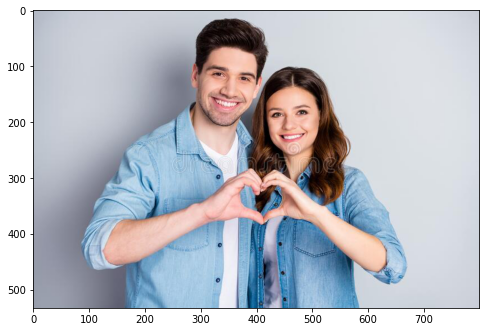

In [ ]:
get_caption_for_image('https://thumbs.dreamstime.com/b/photo-pretty-lady-handsome-guy-couple-love-making-fingers-hands-heart-figure-celebrate-anniversary-valentine-day-lovers-wear-179991896.jpg', True)

In [24]:
# a function to get several predicted captions and save them to a file

def get_batch_captions_results(test_ann_ids):
    unique_img_ids = {}
    results = []
    for i, ann_id in enumerate(test_ann_ids):
      img_id = coco_caps.anns[ann_id]['image_id']
      img_path = coco_caps.loadImgs(img_id)[0]['coco_url']
      img_sampled_caption = get_caption_for_image(img_path)

      # prevent duplicate image_id in the results
      if not img_id in unique_img_ids:
        unique_img_ids[img_id] = None
        results.append({'image_id': img_id, 'caption': img_sampled_caption})
    
    with open('data/captions_val2014_results.json', 'w') as outfile:
      json.dump(results, outfile)

    return results

It is possible to generate a file with several captions and image_ids. In this case, 2.000 captions were generated and saved on a json file. So later, the evaluation toolkit from MS Coco can be used to obtain some metrics.

In [26]:
get_batch_captions_results(test_caps_ann_ids)

[{'caption': 'a bedroom with a bed and a tv', 'image_id': 211107},
 {'caption': 'a group of people sitting around a table with a cake .',
  'image_id': 72656},
 {'caption': 'a table with a bunch of pots and pans', 'image_id': 254016},
 {'caption': 'a man riding a skateboard down a beach .', 'image_id': 391463},
 {'caption': 'a restaurant with a bunch of <unk> and vegetables .',
  'image_id': 405195},
 {'caption': 'a desk with a laptop computer and a monitor',
  'image_id': 237844},
 {'caption': 'a plate with a plate of food on it', 'image_id': 430056},
 {'caption': 'a man in a kitchen with a black cat and a black cat .',
  'image_id': 413900},
 {'caption': 'a man riding a skateboard down a beach .', 'image_id': 376441},
 {'caption': 'a living room with a tv and a tv', 'image_id': 285234},
 {'caption': 'a plate with a plate of food and a cup of coffee .',
  'image_id': 343458},
 {'caption': 'a man sitting on a bench in front of a building .',
  'image_id': 220045},
 {'caption': 'a man s

## Evaluation Metrics

About Rouge Metrics:<br>
"ROUGE: A Package for Automatic Evaluation of Summaries"<br>
http://anthology.aclweb.org/W/W04/W04-1013.pdf<br>
<br>
(nothing in common between sentences) 0 <= ROUGE <= 1 (the sentences are the same)<br>
<br>
**ROUGE-N** - measures unigram, bigram, trigram and higher order n-gram overlap <br>

**ROUGE_L** - It measures the longest matching sequence of words using LCS (longest common subsequence). An advantage of using LCS is that it does not require consecutive matches but in-sequence matches that reflect sentence level word order. Since it automatically includes longest in-sequence common n-grams, you don’t need a predefined n-gram length.<br>
The example below ilustrates how Rouge_L works: <br>
<br>
S1. police killed the gunman (refference sentence)<br>
S2. police kill the gunman <br>
S3. the gunman kill police <br>
<br>
rouge_L (S2) = 3/4 <br>
rouge_L (S3) = 1/2 <br>
<br>
Therefore S2 is better than S3 according to ROUGE-L.

Download the example and files for testing Pycocoevalcap: <br>
https://github.com/salaniz/pycocoevalcap/tree/master/example

In [2]:
# MS COCO Evaluation Metrics - new version for Python 3
# https://github.com/salaniz/pycocoevalcap
# This repository provides Python 3 support 
# for the caption evaluation metrics used for the MS COCO dataset.
# Original git: https://github.com/tylin/coco-caption

!pip install pycocoevalcap

     |████████████████████████████████| 104.3 MB 67 kB/s 


Predictions must be written in a json file with unique image_ids, as following:<br>
```json
[{
  "image_id": 404464, 
  "caption": "black and white photo of a man standing in front of a building"
  }, 
  {
  "image_id": 380932, 
  "caption": "group of people are on the side of a snowy field"
  },
    ...
]
```

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [31]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

# create coco_result object
coco_result = coco_caps.loadRes('data/captions_val2014_results.json')

# create coco_eval object by taking coco and coco_result
coco_eval = COCOEvalCap(coco_caps, coco_result)

# evaluate on a subset of images
coco_eval.params['image_id'] = coco_result.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
coco_eval.evaluate()

# print output evaluation scores
for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')

Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 5359, 'reflen': 5295, 'guess': [5359, 4830, 4301, 3772], 'correct': [3048, 1169, 371, 134]}
ratio: 1.0120868744096294
Bleu_1: 0.569
Bleu_2: 0.371
Bleu_3: 0.228
Bleu_4: 0.143
computing METEOR score...
METEOR: 0.166
computing Rouge score...
ROUGE_L: 0.421
computing CIDEr score...
CIDEr: 0.289
computing SPICE score...
SPICE: 0.086
Bleu_1: 0.569
Bleu_2: 0.371
Bleu_3: 0.228
Bleu_4: 0.143
METEOR: 0.166
ROUGE_L: 0.421
CIDEr: 0.289
SPICE: 0.086


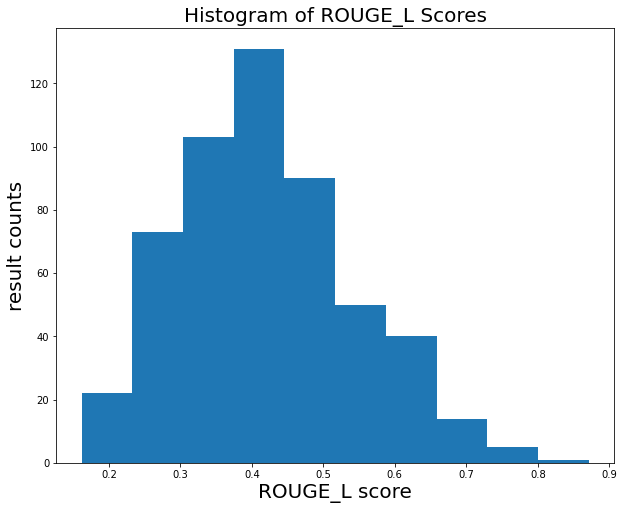

In [33]:
# plot score histogram
rougeScores = [eva['ROUGE_L'] for eva in coco_eval.evalImgs]
plt.hist(rougeScores)
plt.title('Histogram of ROUGE_L Scores', fontsize=20)
plt.xlabel('ROUGE_L score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()